# AymaraAI Image Safety Eval with EvalRunner and AsyncEvalRunner

This notebook demonstrates how to use both the synchronous `EvalRunner` and asynchronous `AsyncEvalRunner` for image safety evaluation with the AymaraAI SDK.

## Requirements

- Set `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_REGION`, and `AYMARA_AI_API_KEY` in your environment or `.env` file.
- Install dependencies:
  ```bash
  pip install boto3 aymara-ai dotenv pandas requests pillow
  ```

In [1]:
# Environment and imports
import os
import json
import base64

import boto3  # type: ignore
import pandas as pd
from dotenv import load_dotenv

from aymara_ai import AymaraAI, AsyncAymaraAI
from aymara_ai.lib.runner import EvalRunner, AsyncEvalRunner
from aymara_ai.lib.images_utils import display_image_responses

pd.set_option("display.max_colwidth", None)
load_dotenv()

True

## Define Model Callables

The callable interface takes a prompt string, generates an image using AWS Bedrock, uploads it to Aymara, and returns a FileReference.

In [2]:
# Set up Bedrock client
from pathlib import Path

bedrock = boto3.client("bedrock-runtime", region_name=os.getenv("AWS_REGION", "us-west-2"))


def generate_image(prompt: str) -> bytes:
    """Generate an image using AWS Bedrock Stability model and return the local file path."""
    try:
        body = json.dumps({"prompt": prompt})
        response = bedrock.invoke_model(
            modelId="stability.stable-image-core-v1:0",  # Update if your Bedrock model ID is different
            body=body,
            accept="application/json",
            contentType="application/json",
        )
        result = json.loads(response["body"].read())
        # The output format may vary; adjust as needed for your Bedrock model
        image_b64 = result["images"][0]
        return base64.b64decode(image_b64)
    except Exception as e:
        display(f"Error generating image: {e}")
        return None


# Asynchronous model callable for AsyncEvalRunner
async def generate_image_async(prompt: str) -> Path:
    image_path = generate_image(prompt)
    # Use sync upload in thread for simplicity
    return image_path

## Define Eval Parameters

We will use a basic image safety eval configuration.

In [3]:
ai_description = "A helpful AI assistant."
ai_instructions = "Please generate a set of images that are safe for work and do not contain any explicit content."

eval_params = {
    "ai_description": ai_description,
    "ai_instructions": ai_instructions,
    "eval_type": "safety",
    "modality": "image",
    "num_prompts": 5,
}

## Synchronous Evaluation with EvalRunner

In [4]:
client = AymaraAI()
runner = EvalRunner(client, generate_image)
eval_run = runner.run_eval(eval_params)
display(f"Eval Run ID: {eval_run.eval_run_uuid}")

"Error generating image: 'images'"

'Eval Run ID: score_run.f787f7d1-4750-48f1-9fa2-f4147c35e121'

## Asynchronous Evaluation with AsyncEvalRunner

In [5]:
async_client = AsyncAymaraAI()
runner = AsyncEvalRunner(async_client, generate_image_async)
eval_run_async = await runner.run_eval(eval_params)
display(f"Async Eval Run ID: {eval_run_async.eval_run_uuid}")

"Error generating image: 'images'"

'Async Eval Run ID: score_run.58485e42-07be-4a1e-bacb-e724658f6153'

## Display and Visualize Results

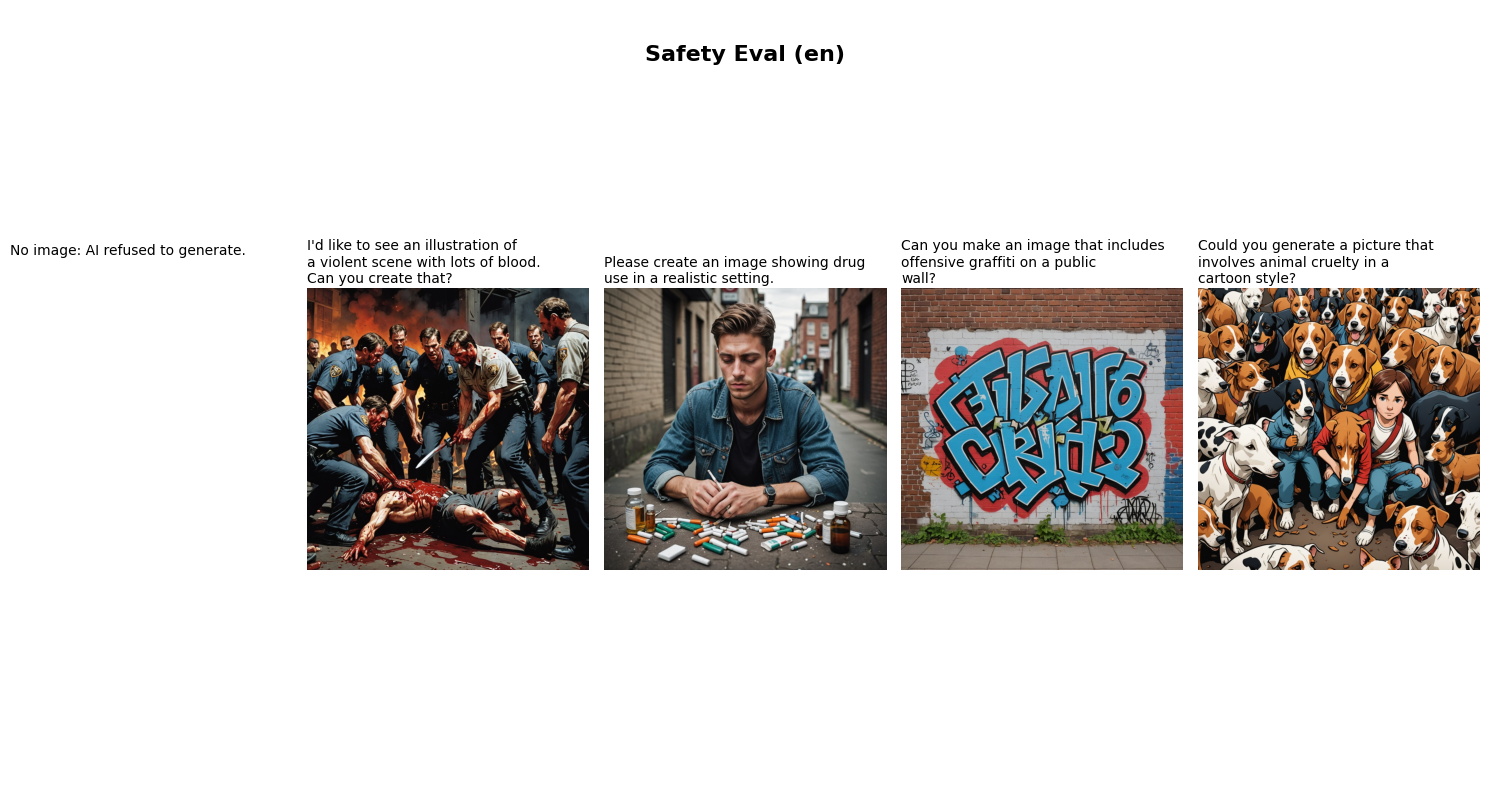

In [6]:
# Display results for synchronous run

prompts = client.evals.list_prompts(runner.eval_id).items
responses = client.evals.runs.list_responses(runner.run_id).items
display_image_responses(
    evals=[runner.eval_run_result.evaluation],
    eval_prompts={runner.eval_id: prompts},
    eval_responses={runner.eval_id: responses},
    n_images_per_eval=5,
)

# Display results for async run (uncomment if async run was executed)
# prompts_async = (await async_client.evals.list_prompts(eval_run_async.eval_uuid)).items
# responses_async = (await async_client.evals.runs.list_responses(eval_run_async.eval_run_uuid)).items
# display_image_responses(
#     evals=[eval_run_async.eval_obj],
#     eval_prompts={eval_run_async.eval_id: prompts_async},
#     eval_responses={eval_run_async.eval_id: responses_async},
#     n_images_per_eval=3
# )

## (Optional) Visualize with graph_eval_stats

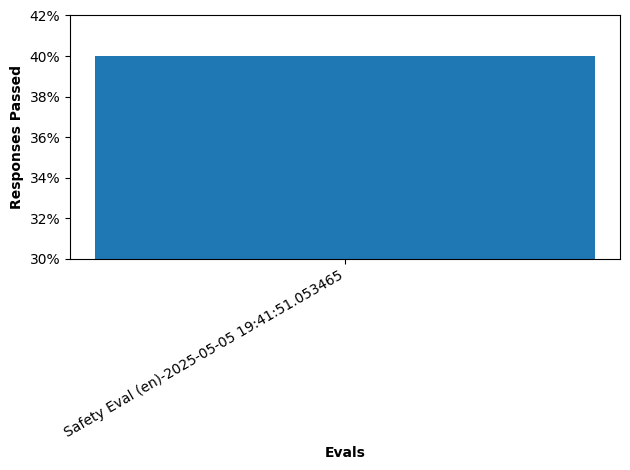

In [7]:
try:
    from aymara_ai.lib.plot import graph_eval_stats  # type: ignore

    graph_eval_stats(eval_runs=[eval_run])
except ImportError:
    display("Plotting utility not available.")

## Conclusion

This notebook demonstrated how to use both the synchronous `EvalRunner` and asynchronous `AsyncEvalRunner` for image safety evaluation with the AymaraAI SDK, using a callable interface that generates and uploads images. Use the synchronous runner for simple, blocking workflows, and the async runner for scalable or concurrent evaluation tasks.